
### Restaurant Menu AI Workflow

#### Initial Setup
- Connect the notebook to a **serverless cluster (v2+)**.
- Create a **volume** and upload an image of the restaurant menu.
- Install all required **dependencies**.

#### Extract Text from the Image
- Use **OCR (Tesseract)** to extract text.
- Alternatively, use a **multimodal generative AI model** for direct extraction.

#### Process the Extracted Menu Text
- If using OCR, process the extracted text with a **Large Language Model (LLM)**.
- If using a multimodal model, parsing is done **directly from the prompt**.

#### Data Intelligence with Genie agent
- Convert the **structured JSON output** into a **Databricks table**.
- Connect the **Genie agent** to the data.
- Perform a **Q&A session** with the agent.




**Note:** The Databricks Agent (beta) is not available in the student version used in this course.

![image_1769620054653.png](./image_1769620054653.png "image_1769620054653.png")

---

### Initial setup

In [0]:
import json
from PIL import Image
import pytesseract

from databricks.sdk import WorkspaceClient
from databricks.sdk.service.serving import ChatMessage, ChatMessageRole

#### Define paths

In [0]:
# output as JSON
json_path = '/Volumes/studies/databricks-studies/ai-agent-volume/cardapio-hoje-infos.json'

In [0]:
# image input 
img_path = '/Volumes/studies/databricks-studies/ai-agent-volume/cardapio-hoje.png'

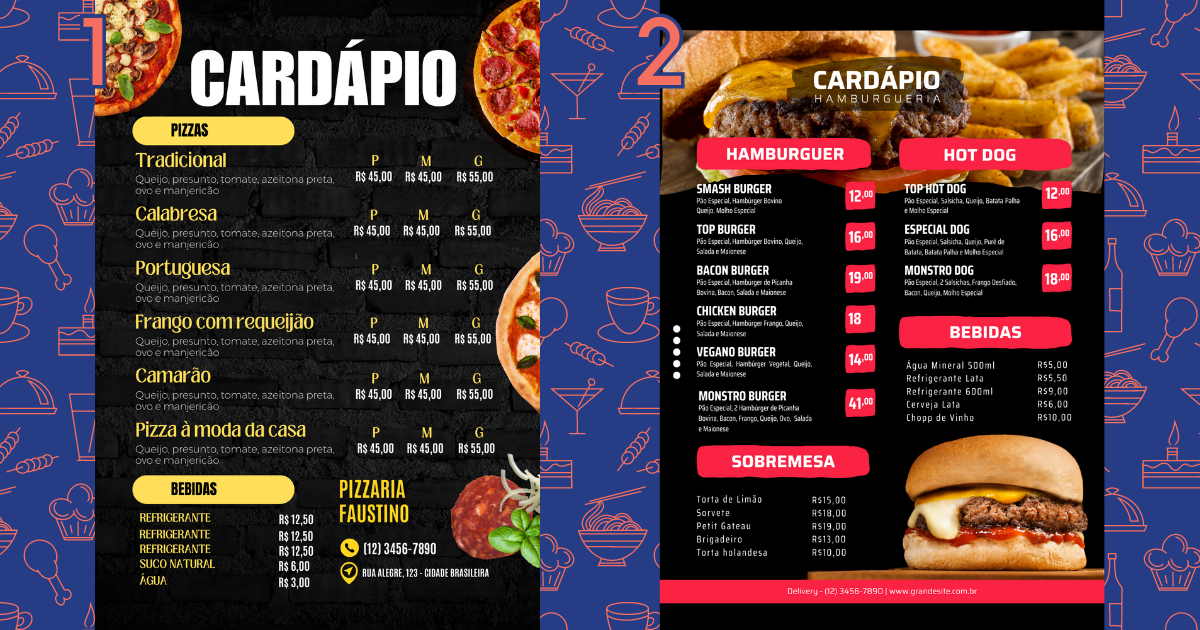

In [0]:
# see the image of restaurant menu
Image.open(img_path).show()

#### Setup catalog and schema

In [0]:
%sql
-- check setups
select current_catalog(), current_schema();

<img src="imgs/sql1.png">

In [0]:
%sql
-- setup to catalog and schema of studies
use catalog `studies`;
use schema `databricks-studies`;

select current_catalog() as actual_catalog,  current_schema() as actual_schema;

actual_catalog,actual_schema
studies,`databricks-studies`


## Extract textual informations

In [0]:
def extract_text_from_image(path: str) -> str:
    '''
    Extract raw text from an image using Tesseract OCR.

    Args:
        path: Path to the image file.

    Returns:
        text: Raw text extracted from the image via OCR.
    '''

    img = Image.open(path)
    
    text = pytesseract.image_to_string(img, lang='eng')
    
    return text

In [0]:
ocr_text = extract_text_from_image(img_path)
print(ocr_text)

=

Calabresa

Pizza amoda da casa
5 x ‘3 prea,
5) BEBIDAS
Cr REFRIGERANTE ay1250
Wy, REFRIGERANTE Ag 1250
REFRIGERANTE AS 12,50.
‘SUCO NATURAL ‘AS 6,00
‘AGUA A$ 3,00

>

M
45,00 $45.00

ie M
45,00 A$ 45,00

(y M
45,00 AS 45,00

Pp M
45,00 AS 45,00

Pp
fs 45,00,

PIZZARIA
FAUSTINO

@ 012) 3456-7890

Q rms suis

M G
is 45,00 A 55,00

CARDAPIO’

HAMBURGUERIA

55,00
G

55,00,
G

5,00,

G
i 55,00,
\VEGANO BURGER

[MONSTRO BURGER

G
55,00 Pe
Cervaja Lata
Chopp de Vino




## Processing raw text with LLM

In [0]:
# instanciate a sdk client

client = WorkspaceClient()

In [0]:
# checking available endpoints of llm on databricks

endpoints = client.serving_endpoints.list()

for endpoint in endpoints:
    print(endpoint.name)

databricks-gpt-5-1-codex-max
databricks-gpt-5-1-codex-mini
databricks-gpt-5-2
databricks-gpt-oss-120b
databricks-gpt-oss-20b
databricks-gpt-5-1
databricks-qwen3-next-80b-a3b-instruct
databricks-llama-4-maverick
databricks-gemma-3-12b
databricks-meta-llama-3-1-8b-instruct
databricks-meta-llama-3-3-70b-instruct
databricks-gte-large-en
databricks-bge-large-en
databricks-meta-llama-3-1-405b-instruct


In [0]:
def call_llm(text: str) -> str:
    '''
    Calls the Databricks LLM endpoint and returns the extracted data.
    '''

    prompt = f'''
        You are a document extraction agent.

        Extract the information below from the text and return *only* a valid JSON:

        Fields:
            - item
            - price
            - description

        Text:
        {text}
    '''

    message = ChatMessage(role=ChatMessageRole.USER, content=prompt)

    response = client.serving_endpoints.query(
        name='databricks-llama-4-maverick',
        messages=[message]
    )

    # Extract the text of the response
    llm_response = response.choices[0].message.content
    print(llm_response)

    res = json.dumps(llm_response, indent=2, ensure_ascii=False)

    # Store output as a JSON file
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(llm_response, f, ensure_ascii=False, indent=2)

    return res


In [0]:
# make parsing with lllm
llm_output = call_llm(ocr_text)

```json
[
  {
    "item": "Calabresa",
    "price": 45.00,
    "description": "Pizza amoda da casa"
  },
  {
    "item": "REFRIGERANTE",
    "price": 12.50,
    "description": null
  },
  {
    "item": "SUCO NATURAL",
    "price": 6.00,
    "description": null
  },
  {
    "item": "AGUA",
    "price": 3.00,
    "description": null
  },
  {
    "item": "MONSTRO BURGER",
    "price": 55.00,
    "description": "VEGANO BURGER"
  },
  {
    "item": "Cervaja Lata",
    "price": null,
    "description": null
  },
  {
    "item": "Chopp de Vino",
    "price": null,
    "description": null
  }
]
```


### Check if the JSON output was generated correctly at the Databricks volume


![image_1769614314899.png](./imgs/image_1769614314899.png "image_1769614314899.png")

### Next Steps

- Save the structured JSON outputs as a table
- Connect the Genie Agent with the table of restaurante menu
- Use a multimodal model to extract the text from the image of input 

### Continuation (next steps) ...

#### Using a multimodal to make the OCR task


In [0]:
json_path = '/Volumes/studies/databricks-studies/ai-agent-volume/cardapio-hoje-infos-llm.json'


def call_llm_ocr(img_path: str) -> str:
    '''
    Calls the Databricks LLM endpoint and returns the extracted data.
    '''

    prompt = f'''
        You are a document extraction agent of images.

        Extract the information below from the image at the input path and return only a valid JSON:

        Fields:
            - item
            - price
            - description

        Image:
        {img_path}
    '''

    message = ChatMessage(role=ChatMessageRole.USER, content=prompt)

    response = client.serving_endpoints.query(
        name='databricks-gemma-3-12b',  # 'databricks-llama-4-maverick',
        messages=[message]
    )

    llm_response = response.choices[0].message.content
    print(llm_response)

    res = json.dumps(llm_response, indent=2, ensure_ascii=False)

    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(llm_response, f, ensure_ascii=False, indent=2)

    return res


In [0]:
# llm_output_ocr = call_llm(img_path)

img_path = '/Volumes/studies/databricks-studies/ai-agent-volume/cardapio-hoje.png'
result = call_llm_ocr(img_path)

print(result)

```json
[
  {
    "item": "Hamburguer",
    "price": "14,90",
    "description": "Pão australiano, Hambúrguer de carne bovina, queijo cheddar, bacon, onion rings, tomate e maionese especial."
  },
  {
    "item": "X-Dog",
    "price": "17,90",
    "description": "Pão especial, salsicha, queijo cheddar, picles, tomate, cebola roxa, milho e maionese."
  },
  {
    "item": "X-Frango",
    "price": "16,90",
    "description": "Pão australiano, filé de frango empanado, queijo cheddar, alface, tomate e maionese."
  },
  {
    "item": "Americano",
    "price": "15,90",
    "description": "Pão australiano, hambúrguer de carne bovina, queijo cheddar, tomate, picles e maionese."
  },
  {
    "item": "Cheese",
    "price": "13,90",
    "description": "Pão australiano, hambúrguer de carne bovina e queijo cheddar."
  },
  {
    "item": "Bacon",
    "price": "15,90",
    "description": "Pão australiano, hambúrguer de carne bovina, queijo cheddar e bacon."
  }
]
```
"```json\n[\n  {\n    \"item\": \"

#### Checking if the output is as expected


![image_1769617578312.png](./imgs/image_1769617578312.png "image_1769617578312.png")

#### Load the output JSON as a sql table

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType


# load the json
ocr_json_path = '/Volumes/studies/databricks-studies/ai-agent-volume/cardapio-hoje-infos-llm.json'
with open(ocr_json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

data = json.loads(re.sub(r"^```json\s*|\s*```$", "", data, flags=re.MULTILINE).strip())

for item in data:
    price_str = item["price"]
    # Remove "R$"
    item["price"] = float(price_str.replace("R$", "").replace(",", ".").strip())

# using Spark to save as a table
spark = SparkSession.builder.getOrCreate()

schema = StructType([
    StructField('item', StringType(), True),
    StructField('price', DoubleType(), True),
    StructField('description', StringType(), True)
])

In [0]:
data

[{'item': 'Hamburguer',
  'price': 14.9,
  'description': 'Pão australiano, Hambúrguer de carne bovina, queijo cheddar, bacon, onion rings, tomate e maionese especial.'},
 {'item': 'X-Dog',
  'price': 17.9,
  'description': 'Pão especial, salsicha, queijo cheddar, picles, tomate, cebola roxa, milho e maionese.'},
 {'item': 'X-Frango',
  'price': 16.9,
  'description': 'Pão australiano, filé de frango empanado, queijo cheddar, alface, tomate e maionese.'},
 {'item': 'Americano',
  'price': 15.9,
  'description': 'Pão australiano, hambúrguer de carne bovina, queijo cheddar, tomate, picles e maionese.'},
 {'item': 'Cheese',
  'price': 13.9,
  'description': 'Pão australiano, hambúrguer de carne bovina e queijo cheddar.'},
 {'item': 'Bacon',
  'price': 15.9,
  'description': 'Pão australiano, hambúrguer de carne bovina, queijo cheddar e bacon.'}]

In [0]:
df_spark = spark.createDataFrame(data, schema=schema)

df_spark.write.format('delta').mode('overwrite').saveAsTable('menu_today_llm')

In [0]:
%sql

SELECT * FROM `menu_today_llm`


item,price,description
Hamburguer,14.9,"Pão australiano, Hambúrguer de carne bovina, queijo cheddar, bacon, onion rings, tomate e maionese especial."
X-Dog,17.9,"Pão especial, salsicha, queijo cheddar, picles, tomate, cebola roxa, milho e maionese."
X-Frango,16.9,"Pão australiano, filé de frango empanado, queijo cheddar, alface, tomate e maionese."
Americano,15.9,"Pão australiano, hambúrguer de carne bovina, queijo cheddar, tomate, picles e maionese."
Cheese,13.9,"Pão australiano, hambúrguer de carne bovina e queijo cheddar."
Bacon,15.9,"Pão australiano, hambúrguer de carne bovina, queijo cheddar e bacon."


#### Connect Genie agent to the table `menu_today_llm`

![image_1769618704800.png](./imgs/image_1769618704800.png "image_1769618704800.png")

![image_1769618969288.png](./imgs/image_1769618969288.png "image_1769618969288.png")